In [3]:
#У нас есть данные о связи lncRNA с участками генома - их можно проассоциировать с генами
#У фантома есть даные о дифф экспрессии генов после нокаута lncRNA - как бы эта РНК регулирует эти гены
#Или надо отобрать те гены, которые начали экспрессироваться после нокаута lncRNA?
# Что мы можем сделать?
#Мы должны взять из фантомных данных список генов, которые диффэкспрессируются у конкретной РНК и сравнить его
#с нашим списком генов для этой РНК - по идее они должны сильно пересекаться

In [300]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [61]:
import pandas as pd
import pickle
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

from BCBio import GFF
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
import mygene
import h5py

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

In [23]:
sns.set(color_codes=True)
rcParams['figure.figsize'] = 15,10
rcParams["patch.force_edgecolor"] = True

In [74]:
#Находим для фантомовских РНК ensembl айдишники из hg19
def makeFantomData():
    fantom = pd.read_csv("/home/ymedvedeva/FANTOM6/data/private/HDF_DE_gene_level/oligo_DE_Summary_gene.tsv", sep="\t")
    fantom = fantom[(fantom['fdr'] < 0.05) & 
       (((fantom['log2FC'] < 0) & (fantom['ZScore'] < -1.645)) | 
        ((fantom['log2FC'] > 0) & (fantom['ZScore'] > 1.645)))][['geneID', 'geneSymbol', 'log2FC', 'KD.geneSymbol', 'perturb_id']]
    
    biomart = pd.read_csv("../fantom6/biomart_results.tsv", sep="\t")
    biomart = biomart[~biomart.duplicated(['KD.geneSymbol'])]
    fantom_merge = pd.merge(fantom, biomart, on='KD.geneSymbol', how='left')
    fantom = fantom_merge[~fantom_merge['KD.geneID'].isna()]
    
    fantom['KD.geneID_ASO'] = [i + "_" + j for i, j in zip(f['KD.geneID'], f['perturb_id'])]
    
    fantom.to_csv("../fantom6/oligo_DE_Summary_gene_filtered.tsv", sep="\t", index=None)
    
    return fantom

In [5]:
#barplot +/- log2FC
def log2FCBarplot():
    ax = sns.barplot(x=['negative log2FC', 'positive log2FC'], y=[101596, 86565])
    ax.set_yticks(range(0, 110000, 10000))
    ax.set(ylabel='DE genes count')
    plt.show()
    
    fig = ax.get_figure()
    fig.patch.set_alpha(0)
    fig.savefig("../H3K27me3/plots/CheckFantomData_log2FC_barplot.png", bbox_inches='tight', pad_inches = 0)

In [6]:
def DEgenesCountLog10Hist():
    ax = sns.distplot(np.log10(fantom.groupby(['KD.geneID'])['geneID'].count()), bins=8, kde=False)
    ax.set_yticks(range(0, 35, 10))
    ax.set_xticks(np.arange(0, 5, 0.5))
    #ax.set_xticklabels(["{:.1e}".format(x) for x in ax.get_xticks()], rotation=30)
    ax.set(xlabel='log10(DE genes count)')
    plt.show()
    
    fig = ax.get_figure()
    fig.patch.set_alpha(0)
    fig.savefig("../H3K27me3/plots/CheckFantomData_DE_genes_count_hist_log_10.png", bbox_inches='tight', pad_inches = 0)

In [47]:
#Ассоциируем наши пики с корреляцией с генами 
def makeLncRNAPeaksGeneAssociation(target, chunk_number=None, annotation_prefix="", 
                                   corrs_file_name="lncRNA_Peaks_Correlations_corrected_non_zero", 
                                   association_file_name="lncRNA_peaks", gene_association_name="peaks"):
    with h5py.File("../all_marks/" + target + "/lncRNA_Peaks_corrs/" + corrs_file_name + ("_" + str(chunk_number) if chunk_number!=None else "") + ".hdf5", 'r') as f:
        corr_shape = f['corrs_matrix'].shape
    
    print("corr = " + str(corr_shape))
    
    with open("../all_marks/" + target + "/" + gene_association_name + ("_" + annotation_prefix if annotation_prefix else "") + "_genes_association.pickle", 'rb') as f:
        ann = pickle.load(f) 
    
    data = None
    d = defaultdict(list)
    for i in range(0, corr_shape[0]):
        with h5py.File("../all_marks/" + target + "/lncRNA_Peaks_corrs/" + corrs_file_name + ("_" + str(chunk_number) if chunk_number!=None else "") + ".hdf5", 'r') as f:
            row = f['corrs_matrix'][i, :]
            lncRNA = f['lncRNAs_names'][i]
        nonzero_corrs = row[np.nonzero(row)[0]]
        nonzero_peaks = ["peak_" + str(i) for i in np.nonzero(row)[0]]
        print("i = " + str(i) + ", " + str(len(nonzero_peaks)) + " nonzero peaks")
        for peak, c in zip(nonzero_peaks, nonzero_corrs):
            #Тут может ничего не быть, пик может не иметь отношения к генам, это норма, ничего не поломается
            try:
                genes = [g.split('.')[0] for g in ann[peak]]
                d['lncRNA'].extend([lncRNA.split('.')[0]]*len(genes))
                d['peak'].extend([peak]*len(genes))
                d['gene'].extend(genes)
                d['corr'].extend([c]*len(genes))
            except KeyError:
                pass
                #print(peak + " doesn't has genes")
            
    df = pd.DataFrame.from_dict(d)
    print("association = " + str(df.shape))
    df.to_csv("../all_marks/" + target + "/" + association_file_name + ("_" + annotation_prefix if annotation_prefix else "") + "_gene_association" + ("_" + str(chunk_number) if chunk_number!=None else "") + ".tsv", sep="\t", index=None)
    d = None
    df = None

In [48]:
makeLncRNAPeaksGeneAssociation("H3K27me3", annotation_prefix='fantom', 
                               corrs_file_name="lncRNA_narrow_2_Peaks_Correlations_corrected_non_zero", 
                                   association_file_name="lncRNA_narrow_2_peaks", gene_association_name="narrow_2_peaks")

corr = (1522, 825354)
i = 0, 17 nonzero peaks
i = 1, 1 nonzero peaks
i = 2, 1 nonzero peaks
i = 3, 1 nonzero peaks
i = 4, 169 nonzero peaks
i = 5, 1 nonzero peaks
i = 6, 13290 nonzero peaks
i = 7, 108 nonzero peaks
i = 8, 2 nonzero peaks
i = 9, 87089 nonzero peaks
i = 10, 16 nonzero peaks
i = 11, 47 nonzero peaks
i = 12, 23736 nonzero peaks
i = 13, 69967 nonzero peaks
i = 14, 42 nonzero peaks
i = 15, 187797 nonzero peaks
i = 16, 1 nonzero peaks
i = 17, 2 nonzero peaks
i = 18, 1 nonzero peaks
i = 19, 41 nonzero peaks
i = 20, 13 nonzero peaks
i = 21, 7395 nonzero peaks
i = 22, 2 nonzero peaks
i = 23, 1 nonzero peaks
i = 24, 1852 nonzero peaks
i = 25, 26498 nonzero peaks
i = 26, 1 nonzero peaks
i = 27, 2405 nonzero peaks
i = 28, 2 nonzero peaks
i = 29, 4 nonzero peaks
i = 30, 2257 nonzero peaks
i = 31, 17 nonzero peaks
i = 32, 1 nonzero peaks
i = 33, 8 nonzero peaks
i = 34, 7380 nonzero peaks
i = 35, 22006 nonzero peaks
i = 36, 1 nonzero peaks
i = 37, 13 nonzero peaks
i = 38, 15 nonzero p

i = 325, 2351 nonzero peaks
i = 326, 19161 nonzero peaks
i = 327, 41836 nonzero peaks
i = 328, 1 nonzero peaks
i = 329, 16918 nonzero peaks
i = 330, 9 nonzero peaks
i = 331, 3531 nonzero peaks
i = 332, 4 nonzero peaks
i = 333, 7 nonzero peaks
i = 334, 4 nonzero peaks
i = 335, 1 nonzero peaks
i = 336, 103 nonzero peaks
i = 337, 9 nonzero peaks
i = 338, 1 nonzero peaks
i = 339, 1179 nonzero peaks
i = 340, 1 nonzero peaks
i = 341, 34855 nonzero peaks
i = 342, 1 nonzero peaks
i = 343, 1 nonzero peaks
i = 344, 4 nonzero peaks
i = 345, 8 nonzero peaks
i = 346, 25 nonzero peaks
i = 347, 4 nonzero peaks
i = 348, 12 nonzero peaks
i = 349, 1 nonzero peaks
i = 350, 6 nonzero peaks
i = 351, 16894 nonzero peaks
i = 352, 2 nonzero peaks
i = 353, 10892 nonzero peaks
i = 354, 541 nonzero peaks
i = 355, 54 nonzero peaks
i = 356, 3 nonzero peaks
i = 357, 1 nonzero peaks
i = 358, 1 nonzero peaks
i = 359, 1 nonzero peaks
i = 360, 687 nonzero peaks
i = 361, 1077 nonzero peaks
i = 362, 23956 nonzero peaks
i

i = 637, 1 nonzero peaks
i = 638, 2316 nonzero peaks
i = 639, 1 nonzero peaks
i = 640, 5 nonzero peaks
i = 641, 2529 nonzero peaks
i = 642, 397 nonzero peaks
i = 643, 44 nonzero peaks
i = 644, 1 nonzero peaks
i = 645, 31084 nonzero peaks
i = 646, 1484 nonzero peaks
i = 647, 1 nonzero peaks
i = 648, 1332 nonzero peaks
i = 649, 12 nonzero peaks
i = 650, 1 nonzero peaks
i = 651, 1 nonzero peaks
i = 652, 6724 nonzero peaks
i = 653, 14332 nonzero peaks
i = 654, 2 nonzero peaks
i = 655, 1 nonzero peaks
i = 656, 1 nonzero peaks
i = 657, 3 nonzero peaks
i = 658, 1304 nonzero peaks
i = 659, 2 nonzero peaks
i = 660, 1 nonzero peaks
i = 661, 1 nonzero peaks
i = 662, 91991 nonzero peaks
i = 663, 167 nonzero peaks
i = 664, 1 nonzero peaks
i = 665, 1 nonzero peaks
i = 666, 815 nonzero peaks
i = 667, 577 nonzero peaks
i = 668, 4 nonzero peaks
i = 669, 1 nonzero peaks
i = 670, 2 nonzero peaks
i = 671, 14 nonzero peaks
i = 672, 163 nonzero peaks
i = 673, 4 nonzero peaks
i = 674, 8460 nonzero peaks
i = 

i = 953, 4959 nonzero peaks
i = 954, 1331 nonzero peaks
i = 955, 10 nonzero peaks
i = 956, 1 nonzero peaks
i = 957, 2 nonzero peaks
i = 958, 74 nonzero peaks
i = 959, 1 nonzero peaks
i = 960, 725 nonzero peaks
i = 961, 3 nonzero peaks
i = 962, 1 nonzero peaks
i = 963, 1 nonzero peaks
i = 964, 8 nonzero peaks
i = 965, 1 nonzero peaks
i = 966, 142 nonzero peaks
i = 967, 693 nonzero peaks
i = 968, 1 nonzero peaks
i = 969, 1 nonzero peaks
i = 970, 12 nonzero peaks
i = 971, 3 nonzero peaks
i = 972, 12 nonzero peaks
i = 973, 7 nonzero peaks
i = 974, 47944 nonzero peaks
i = 975, 43703 nonzero peaks
i = 976, 2 nonzero peaks
i = 977, 7 nonzero peaks
i = 978, 4877 nonzero peaks
i = 979, 1 nonzero peaks
i = 980, 2384 nonzero peaks
i = 981, 13 nonzero peaks
i = 982, 48 nonzero peaks
i = 983, 1 nonzero peaks
i = 984, 1 nonzero peaks
i = 985, 292 nonzero peaks
i = 986, 685 nonzero peaks
i = 987, 29 nonzero peaks
i = 988, 1 nonzero peaks
i = 989, 1338 nonzero peaks
i = 990, 2 nonzero peaks
i = 991, 2

i = 1262, 10 nonzero peaks
i = 1263, 276 nonzero peaks
i = 1264, 145 nonzero peaks
i = 1265, 1947 nonzero peaks
i = 1266, 19 nonzero peaks
i = 1267, 1 nonzero peaks
i = 1268, 4 nonzero peaks
i = 1269, 1 nonzero peaks
i = 1270, 31 nonzero peaks
i = 1271, 3 nonzero peaks
i = 1272, 92328 nonzero peaks
i = 1273, 184 nonzero peaks
i = 1274, 10 nonzero peaks
i = 1275, 1 nonzero peaks
i = 1276, 844 nonzero peaks
i = 1277, 592 nonzero peaks
i = 1278, 1822 nonzero peaks
i = 1279, 1 nonzero peaks
i = 1280, 1 nonzero peaks
i = 1281, 14 nonzero peaks
i = 1282, 18877 nonzero peaks
i = 1283, 1 nonzero peaks
i = 1284, 1 nonzero peaks
i = 1285, 48684 nonzero peaks
i = 1286, 2677 nonzero peaks
i = 1287, 8 nonzero peaks
i = 1288, 3 nonzero peaks
i = 1289, 3 nonzero peaks
i = 1290, 4343 nonzero peaks
i = 1291, 2 nonzero peaks
i = 1292, 20 nonzero peaks
i = 1293, 1 nonzero peaks
i = 1294, 1 nonzero peaks
i = 1295, 2 nonzero peaks
i = 1296, 23 nonzero peaks
i = 1297, 2 nonzero peaks
i = 1298, 51 nonzero pe

In [44]:
def makePeaksGenesAssociation(target, annotation_prefix="", gene_association_name="peaks"):
    annotation_prefix = "_" + annotation_prefix if annotation_prefix else ""
    
    data = pd.read_csv("../all_marks/" + target + "/" + gene_association_name + annotation_prefix + "_anno.csv", sep="\t")
    ann = data.groupby('peak')['feature'].apply(list).to_dict()
    
    with open("../all_marks/" + target + "/" + gene_association_name + annotation_prefix + "_genes_association.pickle", 'wb') as f:
        pickle.dump(ann, f)

In [45]:
makePeaksGenesAssociation("H3K27me3", "fantom", "narrow_2_peaks")

In [29]:
def checkSigns(x):
    return (all(item >= 0 for item in x) or all(item < 0 for item in x) if len(x) > 1 else True)

In [41]:
#Это нужно только если у нас не фантомовская аннотация!!
def makeCommonGeneSet(target, annotation_prefix = ""):
    if annotation_prefix == "":
        in_file = "../annotation/gencode.v31.annotation.gff3"
        in_handle = open(in_file)

        limit_info = dict(
            gff_id = ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 
         'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX', 'chrY'],
            gff_type = ["gene"])

        gencode31_genes = []
        for rec in GFF.parse(in_handle, limit_info=limit_info):
            gencode31_genes.append(rec.features) 

        in_handle.close()

        gencode31_genes = [g.qualifiers['gene_id'][0].split('.')[0] for cr in gencode31_genes for g in cr]

        #Фантомовские гены, среди которых выбирали деги - это не все гены из аннотации фантома!
        f = pd.read_csv("../fantom6/expression.log2CPM.TMM.gene.nAnT-iCAGE.ASO.human_dermal_fibroblasts.tsv", sep="\t")
        fantom_all_genes = [g for g in f['geneID'] if g.startswith("ENSG")]
        common_our_fantom_genes = np.array(list(set(gencode31_genes).intersection(set(fantom_all_genes))), dtype='object')
    elif annotation_prefix == "fantom":
        f = pd.read_csv("../fantom6/expression.log2CPM.TMM.gene.nAnT-iCAGE.ASO.human_dermal_fibroblasts.tsv", sep="\t")
        common_our_fantom_genes = np.array(f['geneID'].tolist(), dtype='object')
    else:
        print("Других аннотаций пока не обрабатываем! ошибка!!")
        return
    
    
    print(common_our_fantom_genes.shape)
    with h5py.File("../all_marks/" + target + "/our_fantom" + ("_" + annotation_prefix if annotation_prefix else "") + "_genes_common_set.hdf5", 'w') as f:
        string_dt = h5py.special_dtype(vlen=str)
        f.create_dataset("set", data=np.array(common_our_fantom_genes, dtype='object'), dtype=string_dt)
        

In [8]:
def our_fantom_lncRNAs_intersection(our, fantom):
    return [lnc for lnc in fantom if lnc.split('_')[0] in our]

In [49]:
#Первая буква это корреляции, вторая - log2FC
#Разделение по ASO начинается сдесь, до этого его нет, потому что до этого мы не работаем с фантомом
def makeCounts(target, is_methylation=False, annotation_prefix="", gene_set_prefix="fantom", 
               association_file_name="lncRNA_peaks", our_fantom_file_name="our_fantom"):
    
    annotation_prefix = "_" + annotation_prefix if annotation_prefix else ""
    
    def makeLists(peak_gene_association, chunk_number=None):
        print("chunk number: " + str(chunk_number))
        df = pd.read_csv(peak_gene_association, sep="\t")
        
        if(not is_methylation):
            df['gene'] = [g.split('.')[0] for g in df['gene']]
            
        fantom = pd.read_csv("../fantom6/oligo_DE_Summary_gene_filtered.tsv", sep="\t")
    
        lncRNAs_fantom = set(fantom['KD.geneID_ASO'].unique())
        lncRNAs_our = set(df['lncRNA'].unique())
    
        partial_genes_lists = {}
        i = 0
        for l in our_fantom_lncRNAs_intersection(lncRNAs_our, lncRNAs_fantom):
            l_without_aso = l.split('_')[0]
            print(l)
            tmp = {}
            ourGenes = df[(df['lncRNA'] == l_without_aso) & (df['gene'].isin(our_fantom_genes_common_set))]['gene'].unique()
            ourGenes_plus_corr = df[(df['lncRNA'] == l_without_aso) & (df['corr'] > 0) & (df['gene'].isin(our_fantom_genes_common_set))]['gene'].unique()
            ourGenes_minus_corr = df[(df['lncRNA'] == l_without_aso) & (df['corr'] < 0) & (df['gene'].isin(our_fantom_genes_common_set))]['gene'].unique()
            fantomGenes = fantom[(fantom['KD.geneID_ASO'] == l)& (fantom['geneID'].isin(our_fantom_genes_common_set))]['geneID'].unique()
            fantomGenes_plus_log2fc = fantom[(fantom['KD.geneID_ASO'] == l) & (fantom['log2FC'] > 0) & (fantom['geneID'].isin(our_fantom_genes_common_set))]['geneID'].unique()
            fantomGenes_minus_log2fc = fantom[(fantom['KD.geneID_ASO'] == l) & (fantom['log2FC'] < 0) & (fantom['geneID'].isin(our_fantom_genes_common_set))]['geneID'].unique()
            tmp['our'] = ourGenes
            tmp['our_plus'] = ourGenes_plus_corr
            tmp['our_minus'] = ourGenes_minus_corr
            tmp['fantom'] = fantomGenes
            tmp['fantom_plus'] = fantomGenes_plus_log2fc
            tmp['fantom_minus'] = fantomGenes_minus_log2fc
            partial_genes_lists[l] = tmp
            i = i + 1
        
        print("pickle dump " + "../all_marks/" + target + "/" + our_fantom_file_name + annotation_prefix + "_genes_association" + ("_" + str(chunk_number) if chunk_number or chunk_number == 0 else "") + ".pickle")
        with open("../all_marks/" + target + "/" + our_fantom_file_name + annotation_prefix + "_genes_association" + ("_" + str(chunk_number) if chunk_number or chunk_number == 0 else "") + ".pickle", 'wb') as f:
            pickle.dump(partial_genes_lists, f) 
            
        return partial_genes_lists
    
    with h5py.File("../all_marks/" + target + "/our_fantom_" + gene_set_prefix + "_genes_common_set.hdf5", 'r') as f:
        our_fantom_genes_common_set = f['set'][:]
    
    if(is_methylation):
        genes_lists = {}
        for i in range(0, 19):
            genes_lists.update(makeLists("../all_marks/" + target + "/" + association_file_name + "_" + gene_set_prefix + "_gene_association_" + str(i) + ".tsv", chunk_number=i))
    else:
        genes_lists = makeLists("../all_marks/" + target + "/" + association_file_name + "_" + gene_set_prefix + "_gene_association.tsv")
        
    fantom = pd.read_csv("../fantom6/oligo_DE_Summary_gene_filtered.tsv", sep="\t")
    d = defaultdict(list)
    for key, value in genes_lists.items():
        d['lncRNAId'].append(key)
        d['lncRNAName'].append(fantom[fantom['KD.geneID_ASO'] == key].iloc[0]['KD.geneSymbol'])
        d['our'].append(len(value['our']))
        d['our_p'].append(len(value['our_plus']))
        d['our_m'].append(len(value['our_minus']))
        d['fantom'].append(len(value['fantom']))
        d['fantom_p'].append(len(value['fantom_plus']))
        d['fantom_m'].append(len(value['fantom_minus']))
        d['intersection'].append(len(set(value['our']).intersection(set(value['fantom']))))
        d['mm_intersection'].append(len(set(value['our_minus']).intersection(set(value['fantom_minus']))))
        d['mp_intersection'].append(len(set(value['our_minus']).intersection(set(value['fantom_plus']))))
        d['pm_intersection'].append(len(set(value['our_plus']).intersection(set(value['fantom_minus']))))
        d['pp_intersection'].append(len(set(value['our_plus']).intersection(set(value['fantom_plus']))))
        
    df = pd.DataFrame.from_dict(d)
    df = df[df['intersection'] != 0]
    df.to_csv("../all_marks/" + target + "/" + our_fantom_file_name + annotation_prefix + "_genes_association.tsv", sep="\t", index=None)
    
    return df

In [50]:
makeCounts("H3K27me3", is_methylation=False, annotation_prefix="fantom_aso", gene_set_prefix="fantom", 
               association_file_name="lncRNA_narrow_2_peaks", our_fantom_file_name="narrow_2_our_fantom")

chunk number: None
ENSG00000240875_ASO_G0240875_10
ENSG00000234327_ASO_G0234327_07
ENSG00000234456_ASO_G0234456_01
ENSG00000234456_ASO_G0234456_04
ENSG00000225733_ASO_G0225733_AD_03
ENSG00000256268_ASO_G0256268_AD_06
ENSG00000271122_ASO_G0271122_05
ENSG00000221817_ASO_G0221817_04
ENSG00000223485_ASO_G0223485_AD_04
ENSG00000263072_ASO_G0263072_05
ENSG00000231312_ASO_G0231312_02
ENSG00000234608_ASO_G0234608_06
ENSG00000230074_ASO_G0230074_05
ENSG00000263072_ASO_G0263072_02
ENSG00000269834_ASO_G0269834_02
ENSG00000245937_ASO_G0245937_01
ENSG00000260565_ASO_G0260565_AD_06
ENSG00000233396_ASO_G0233396_07
ENSG00000224086_ASO_G0224086_04
ENSG00000225791_ASO_G0225791_05
ENSG00000268895_ASO_G0268895_03
ENSG00000228526_ASO_G0228526_10
ENSG00000229847_ASO_G0229847_AD_02
ENSG00000214548_ASO_G0214548_AD_09
ENSG00000269834_ASO_G0269834_AD_02
ENSG00000263072_ASO_G0263072_06
ENSG00000246273_ASO_G0246273_02
ENSG00000212978_ASO_G0212978_02
ENSG00000255121_ASO_G0255121_02
ENSG00000268895_ASO_G0268895_01


,lncRNAId,lncRNAName,our,our_p,our_m,fantom,fantom_p,fantom_m,intersection,mm_intersection,mp_intersection,pm_intersection,pp_intersection
2,ENSG00000234456_ASO_G0234456_01,MAGI2-AS3,820,215,610,26,1,25,2,2,0,0,0
3,ENSG00000234456_ASO_G0234456_04,MAGI2-AS3,820,215,610,52,9,43,1,0,0,1,0
4,ENSG00000225733_ASO_G0225733_AD_03,FGD5-AS1,374,89,288,815,331,484,22,13,6,0,3
5,ENSG00000256268_ASO_G0256268_AD_06,RP11-221N13.3,4970,491,4602,90,24,66,36,27,8,2,0
8,ENSG00000223485_ASO_G0223485_AD_04,RP11-417E7.1,4,2,2,4157,1841,2316,2,0,1,1,0
10,ENSG00000231312_ASO_G0231312_02,AC007246.3,48,0,48,611,228,383,4,4,0,0,0
11,ENSG00000234608_ASO_G0234608_06,MAPKAPK5-AS1,6641,1846,5479,1392,555,837,515,335,125,73,35
16,ENSG00000260565_ASO_G0260565_AD_06,ERVK13-1,2040,1811,254,14,0,14,1,0,0,1,0
17,ENSG00000233396_ASO_G0233396_07,RP11-458D21.1,3307,1043,2424,7751,3613,4138,1177,499,382,125,225
19,ENSG00000225791_ASO_G0225791_05,TRAM2-AS1,2402,805,1662,3,0,3,2,2,0,0,0


In [42]:
def paintCounts(target, annotation_prefix=""):
    
    def color_signif_red(row):
        lncRNAId = row[0]
        tmp = signif[lncRNAId]

        return ['color: black']*8 + ['color: %s' % tmp[0]] + ['color: %s' % tmp[1]] + ['color: %s' % tmp[2]] + ['color: %s' % tmp[3]] + ['color: %s' % tmp[4]]
    annotation_prefix = "_" + annotation_prefix if annotation_prefix else ""
    df = pd.read_csv("../all_marks/" + target + "/our_fantom" + annotation_prefix + "_genes_association.tsv", sep="\t")
    df_pv = pd.read_csv("../all_marks/" + target + "/our_fantom" + annotation_prefix + "_genes_association_pvalues.tsv", sep="\t")
    
    signif = {}
    for i, row in df_pv.iterrows():
        tmp = []
        if(row['pvalue'] < 0.05):
            tmp.append('red')
        else:
            tmp.append('black')

        if(row['mm_pvalue'] < 0.05):
            tmp.append('red')
        else:
            tmp.append('black')

        if(row['mp_pvalue'] < 0.05):
            tmp.append('red')
        else:
            tmp.append('black')

        if(row['pm_pvalue'] < 0.05):
            tmp.append('red')
        else:
            tmp.append('black')

        if(row['pp_pvalue'] < 0.05):
            tmp.append('red')
        else:
            tmp.append('black')
        
        signif[row['lncRNAId']] = tmp
    #return signif
    s = df[df['lncRNAId'].isin(df_pv['lncRNAId'])].style.apply(color_signif_red, axis=1)
    return s

In [43]:
def makeHtmlTable(s, path):
    with open(path, 'w') as f:
        for index, item in enumerate(s.render().split("\n")):
            if(index == 0):
                f.write('<style  type="text/css" >\n')
                f.write('\n')
                f.write('table, th, td {\n')
                f.write('border: 1px solid black;\n')
                f.write('border-collapse: collapse;\n')
                f.write('font-size: 11px;\n')
                f.write('}\n')
                f.write('\n')
                f.write('th,\n')
                f.write('td {\n')
                f.write('border: 1px solid black;\n')
                f.write('width: 100px;\n')
                f.write('height: 25px;\n')
                f.write('text-align:center;\n')
                f.write('font-family: Montserrat;\n')
                f.write('overflow: hidden;\n')
                f.write('}\n')
                f.write('\n')
                f.write('tr:nth-child(even) {\n')
                f.write('background-color: #ffe6e6\n')
                f.write('}\n')
                f.write('\n')
            else:
                f.write("%s\n" % item)

In [53]:
# TODO: почему без lncRNA??
def makeConfusionMatrix(target, annotation_prefix="", our_fantom_file_name="", common_genes_set_length=18981):
    annotation_prefix = "_" + annotation_prefix if annotation_prefix else ""
    df = pd.read_csv("../all_marks/" + target + "/" + our_fantom_file_name + annotation_prefix + "_genes_association.tsv", sep="\t") 
    
    confuion_df = {}

    confuion_df['TP'] = df['intersection']
    confuion_df['FP'] = df['our'] - df['intersection']
    confuion_df['FN'] = df['fantom'] - df['intersection']
    confuion_df['TN'] = common_genes_set_length - df['our'] - df['fantom'] + df['intersection']

    confuion_df['mm_TP'] = df['mm_intersection']
    confuion_df['mm_FP'] = df['our_m'] - df['mm_intersection']
    confuion_df['mm_FN'] = df['fantom_m'] - df['mm_intersection']
    confuion_df['mm_TN'] = common_genes_set_length - df['our_m'] - df['fantom_m'] + df['mm_intersection']

    confuion_df['mp_TP'] = df['mp_intersection']
    confuion_df['mp_FP'] = df['our_m'] - df['mp_intersection']
    confuion_df['mp_FN'] = df['fantom_p'] - df['mp_intersection']
    confuion_df['mp_TN'] = common_genes_set_length - df['our_m'] - df['fantom_p'] + df['mp_intersection']

    confuion_df['pm_TP'] = df['pm_intersection']
    confuion_df['pm_FP'] = df['our_p'] - df['pm_intersection']
    confuion_df['pm_FN'] = df['fantom_m'] - df['pm_intersection']
    confuion_df['pm_TN'] = common_genes_set_length - df['our_p'] - df['fantom_m'] + df['pm_intersection']

    confuion_df['pp_TP'] = df['pp_intersection']
    confuion_df['pp_FP'] = df['our_p'] - df['pp_intersection']
    confuion_df['pp_FN'] = df['fantom_p'] - df['pp_intersection']
    confuion_df['pp_TN'] = common_genes_set_length - df['our_p'] - df['fantom_p'] + df['pp_intersection']
    
    confuion_df = pd.DataFrame(confuion_df)
    confuion_df.to_csv("../all_marks/" + target + "/" + our_fantom_file_name + annotation_prefix + "_genes_confusion_matrix.tsv", sep="\t", index="None")

In [54]:
makeConfusionMatrix("H3K27me3", "fantom_aso", our_fantom_file_name="narrow_2_our_fantom")

In [45]:
def makeConfusionMatrixExample():
    #TP	FP	FN	TN
    #155	1396	4049	13381
    d = {'corr_genes': ['intersection = 155', 'our_genes - intersection = 1396'], 
         'no_corr_genes': ['fantom_genes - intersection = 4049', '18981 - our_genes - fantom_genes + intersection = 13381']}
    f = pd.DataFrame(d)
    f.index = ['fantom_genes', 'no_fantom_genes']
    pd.set_option('display.max_colwidth',1000)
    return f

In [55]:
def makeExactFisherTest(target, annotation_prefix="", our_fantom_file_name=""):
    annotation_prefix = "_" + annotation_prefix if annotation_prefix else ""
    confuion_df = pd.read_csv("../all_marks/" + target + "/" + our_fantom_file_name + annotation_prefix + "_genes_confusion_matrix.tsv", sep="\t") 
    df = pd.read_csv("../all_marks/" + target + "/" + our_fantom_file_name + annotation_prefix + "_genes_association.tsv", sep="\t") 
    
    pvalue = []
    mm_pvalue = []
    mp_pvalue = []
    pm_pvalue = []
    pp_pvalue = []
    for index, row in confuion_df.iterrows():
        _, pv = stats.fisher_exact([[row['TP'], row['FP']], [row['FN'], row['TN']]])
        pvalue.append(pv)

        _, mm_pv = stats.fisher_exact([[row['mm_TP'], row['mm_FP']], [row['mm_FN'], row['mm_TN']]])
        mm_pvalue.append(mm_pv)

        _, mp_pv = stats.fisher_exact([[row['mp_TP'], row['mp_FP']], [row['mp_FN'], row['mp_TN']]])
        mp_pvalue.append(mp_pv)

        _, pm_pv = stats.fisher_exact([[row['pm_TP'], row['pm_FP']], [row['pm_FN'], row['pm_TN']]])
        pm_pvalue.append(pm_pv)

        _, pp_pv = stats.fisher_exact([[row['pp_TP'], row['pp_FP']], [row['pp_FN'], row['pp_TN']]])  
        pp_pvalue.append(pp_pv)
        
    adjusted_pvalue = multipletests(pvalue, alpha=0.05, method='fdr_bh')
    adjusted_mm_pvalue = multipletests(mm_pvalue, alpha=0.05, method='fdr_bh')
    adjusted_mp_pvalue = multipletests(mp_pvalue, alpha=0.05, method='fdr_bh')
    adjusted_pm_pvalue = multipletests(pm_pvalue, alpha=0.05, method='fdr_bh')
    adjusted_pp_pvalue = multipletests(pp_pvalue, alpha=0.05, method='fdr_bh')
    
    pvalue_df = pd.DataFrame({'pvalue': adjusted_pvalue[1], 'mm_pvalue': adjusted_mm_pvalue[1], 
                              'mp_pvalue': adjusted_mp_pvalue[1], 'pm_pvalue': adjusted_pm_pvalue[1], 
                              'pp_pvalue': adjusted_pp_pvalue[1]})
    
    df_pv = pd.concat([df[['lncRNAId', 'lncRNAName']], pvalue_df], axis = 1)
    df_pv = df_pv[df_pv.apply(lambda row: len([p for p in row.tolist()[3:] if float(p) < 0.05]) != 0, axis=1)]
    df_pv.to_csv("../all_marks/" + target + "/" + our_fantom_file_name + annotation_prefix + "_genes_association_pvalues.tsv", sep="\t", index=None)

In [56]:
makeExactFisherTest("H3K27me3", "fantom_aso", our_fantom_file_name="narrow_2_our_fantom")

In [57]:
def paintPvalueMatrix(target, annotation_prefix="", our_fantom_file_name=""):
    def color_negative_red(val):
        try:
            color = 'red' if val < 0.05 else 'black'
        except Exception:
            color = 'black'
        return 'color: %s' % color
    
    df_pv = pd.read_csv("../all_marks/" + target + "/" + our_fantom_file_name + ("_" + annotation_prefix if annotation_prefix else "") + "_genes_association_pvalues.tsv", sep="\t")
    df_pv = df_pv[['lncRNAId', 'lncRNAName', 'mm_pvalue', 'mp_pvalue', 'pm_pvalue', 'pp_pvalue']]
    df_pv = df_pv.rename(columns={'mm_pvalue':'ea_pvalue', 'mp_pvalue':'er_pvalue', 'pm_pvalue':'wa_pvalue', 'pp_pvalue':'wr_pvalue'})
    df_pv = df_pv[['lncRNAId', 'lncRNAName', 'wa_pvalue', 'ea_pvalue', 'wr_pvalue', 'er_pvalue']]
    
    s = df_pv.sort_values(['lncRNAId']).style.applymap(color_negative_red)
    #s.render().split("\n")
    return s

In [59]:
paintPvalueMatrix("H3K27me3", "fantom_aso", our_fantom_file_name="our_fantom")

,lncRNAId,lncRNAName,wa_pvalue,ea_pvalue,wr_pvalue,er_pvalue
11,ENSG00000212978_ASO_G0212978_01,AC016747.3,1,0.00124286,1,1
1,ENSG00000212978_ASO_G0212978_02,AC016747.3,1,0.00290526,1,1
0,ENSG00000212978_ASO_G0212978_03,AC016747.3,0.358742,5.36518e-09,1,1
9,ENSG00000227053_ASO_G0227053_03,RP11-395B7.4,1,0.00108101,1,1
5,ENSG00000233396_ASO_G0233396_07,RP11-458D21.1,5.60714e-13,1.25187e-15,5.48913e-28,1
2,ENSG00000234608_ASO_G0234608_06,MAPKAPK5-AS1,0.00496038,1.83513e-31,0.426677,1
4,ENSG00000234608_ASO_G0234608_AD_04,MAPKAPK5-AS1,0.0425168,0.000354263,1,1
10,ENSG00000246273_ASO_G0246273_02,SBF2-AS1,0.147024,0.00416051,1,0.360778
3,ENSG00000253161_ASO_C013368_02,RP11-150O12.1,1,0.00479929,1,0.0676221
7,ENSG00000256268_ASO_G0256268_AD_06,RP11-221N13.3,0.410615,0.000861513,1,1


In [40]:
paintPvalueMatrix("H3K27me3", "fantom_aso", our_fantom_file_name="broad_2_our_fantom")

,lncRNAId,lncRNAName,wa_pvalue,ea_pvalue,wr_pvalue,er_pvalue
7,ENSG00000212978_ASO_G0212978_01,AC016747.3,1,0.00627366,1,1
6,ENSG00000212978_ASO_G0212978_02,AC016747.3,1,0.0205374,1,1
12,ENSG00000212978_ASO_G0212978_03,AC016747.3,1,0.000402098,1,0.0126029
0,ENSG00000225733_ASO_G0225733_AD_03,FGD5-AS1,1,0.0114277,1,0.752858
4,ENSG00000225791_ASO_G0225791_05,TRAM2-AS1,1,0.0307923,1,1
10,ENSG00000227053_ASO_G0227053_03,RP11-395B7.4,1,2.61887e-17,1,0.120683
11,ENSG00000227053_ASO_G0227053_04,RP11-395B7.4,1,0.000257987,1,0.00776972
8,ENSG00000231185_ASO_G0231185_03,AC005592.2,1,0.00233582,1,1
3,ENSG00000233396_ASO_G0233396_07,RP11-458D21.1,1.54832e-30,0.0401092,0.133803,1.82527e-05
2,ENSG00000234608_ASO_G0234608_06,MAPKAPK5-AS1,1,6.56869e-41,0.00412424,1.82527e-05


In [58]:
paintPvalueMatrix("H3K27me3", "fantom_aso", our_fantom_file_name="narrow_2_our_fantom")

,lncRNAId,lncRNAName,wa_pvalue,ea_pvalue,wr_pvalue,er_pvalue
5,ENSG00000227053_ASO_G0227053_03,RP11-395B7.4,1,6.24479e-14,1,0.120365
6,ENSG00000227053_ASO_G0227053_04,RP11-395B7.4,1,0.103058,1,0.0285325
7,ENSG00000231185_ASO_G0231185_02,AC005592.2,0.462245,0.0465067,1,1
4,ENSG00000231185_ASO_G0231185_03,AC005592.2,1,0.0334764,1,0.377775
2,ENSG00000233396_ASO_G0233396_07,RP11-458D21.1,2.32765e-15,0.341401,0.818109,0.00037987
1,ENSG00000234608_ASO_G0234608_06,MAPKAPK5-AS1,0.998468,3.93116e-11,0.21117,0.0169942
3,ENSG00000246273_ASO_G0246273_02,SBF2-AS1,0.756357,0.0592155,1,0.0493314
0,ENSG00000256268_ASO_G0256268_AD_06,RP11-221N13.3,1,0.0412193,1,1


In [48]:
#barplot over all, pp, pm, mp, mm
def variantsBarplot():
    ax = sns.barplot(x=['all', 'mm', 'mp', 'pm', 'pp'], y=[11, 18, 8, 8, 7])
    ax.set_yticks(range(0, 19))
    ax.set(ylabel='lncRNA count')
    ax.set(xlabel='correlation sign-log2FC sign pvalue')
    plt.show()
    
    fig = ax.get_figure()
    fig.patch.set_alpha(0)
    fig.savefig("../H3K27me3/plots/CheckFantomData_our_fantom_genes_association_pvalues_barplot.png", bbox_inches='tight', pad_inches = 0)

In [66]:
targets = [("H3K27ac", "_narrow"), ("H3K36me3", ""), 
           ("H3K4me1", "_narrow"), ("H3K4me2", "_narrow"), ("H3K4me3", "_narrow"), ("H3K79me2", ""), 
           ("H3K9ac", "_narrow"), ("H3K9me3", ""), ("H4K20me1", ""), ("H3K27me3", ""), ("methylation", "")]

In [30]:
for target in targets:
    print(target[0])
    print("makeCommonGeneSet...")
    makeCommonGeneSet(target[0])
    print("makeLncRNAPeaksGeneAssociation...")
    makeLncRNAPeaksGeneAssociation(target[0])
    print("makeCounts...")
    makeCounts(target[0])
    print("makeConfusionMatrix...")
    makeConfusionMatrix(target[0])
    print("makeExactTARIDFisherTest...")
    makeExactFisherTest(target[0])

H3K36me3
makeCommonGeneSet...
(18328,)
makeLncRNAPeaksGeneAssociation...
corr = (1321, 424010)
i = 0, 48 nonzero peaks
i = 1, 7679 nonzero peaks
i = 2, 1003 nonzero peaks
i = 3, 3 nonzero peaks
i = 4, 5 nonzero peaks
i = 5, 6 nonzero peaks
i = 6, 1172 nonzero peaks
i = 7, 1 nonzero peaks
i = 8, 3941 nonzero peaks
i = 9, 46794 nonzero peaks
i = 10, 35 nonzero peaks
i = 11, 58801 nonzero peaks
i = 12, 1 nonzero peaks
i = 13, 1 nonzero peaks
i = 14, 203 nonzero peaks
i = 15, 12300 nonzero peaks
i = 16, 31 nonzero peaks
i = 17, 21 nonzero peaks
i = 18, 60672 nonzero peaks
i = 19, 282 nonzero peaks
i = 20, 1 nonzero peaks
i = 21, 1093 nonzero peaks
i = 22, 74 nonzero peaks
i = 23, 1 nonzero peaks
i = 24, 1 nonzero peaks
i = 25, 3 nonzero peaks
i = 26, 1416 nonzero peaks
i = 27, 11 nonzero peaks
i = 28, 1952 nonzero peaks
i = 29, 1097 nonzero peaks
i = 30, 62 nonzero peaks
i = 31, 4 nonzero peaks
i = 32, 3 nonzero peaks
i = 33, 6542 nonzero peaks
i = 34, 67 nonzero peaks
i = 35, 135 nonzero 

i = 316, 389 nonzero peaks
i = 317, 2 nonzero peaks
i = 318, 1 nonzero peaks
i = 319, 50619 nonzero peaks
i = 320, 2 nonzero peaks
i = 321, 8 nonzero peaks
i = 322, 27 nonzero peaks
i = 323, 361 nonzero peaks
i = 324, 1 nonzero peaks
i = 325, 1 nonzero peaks
i = 326, 846 nonzero peaks
i = 327, 1437 nonzero peaks
i = 328, 197 nonzero peaks
i = 329, 4694 nonzero peaks
i = 330, 3 nonzero peaks
i = 331, 1 nonzero peaks
i = 332, 8044 nonzero peaks
i = 333, 537 nonzero peaks
i = 334, 11 nonzero peaks
i = 335, 11867 nonzero peaks
i = 336, 1 nonzero peaks
i = 337, 1 nonzero peaks
i = 338, 461 nonzero peaks
i = 339, 86 nonzero peaks
i = 340, 4271 nonzero peaks
i = 341, 1 nonzero peaks
i = 342, 10 nonzero peaks
i = 343, 6588 nonzero peaks
i = 344, 9 nonzero peaks
i = 345, 4 nonzero peaks
i = 346, 945 nonzero peaks
i = 347, 1 nonzero peaks
i = 348, 4 nonzero peaks
i = 349, 922 nonzero peaks
i = 350, 165 nonzero peaks
i = 351, 97 nonzero peaks
i = 352, 723 nonzero peaks
i = 353, 1077 nonzero peaks

i = 631, 3 nonzero peaks
i = 632, 3382 nonzero peaks
i = 633, 1 nonzero peaks
i = 634, 1 nonzero peaks
i = 635, 1 nonzero peaks
i = 636, 1 nonzero peaks
i = 637, 1 nonzero peaks
i = 638, 17730 nonzero peaks
i = 639, 26 nonzero peaks
i = 640, 7 nonzero peaks
i = 641, 252 nonzero peaks
i = 642, 1 nonzero peaks
i = 643, 3 nonzero peaks
i = 644, 1987 nonzero peaks
i = 645, 43836 nonzero peaks
i = 646, 1 nonzero peaks
i = 647, 1 nonzero peaks
i = 648, 13 nonzero peaks
i = 649, 1 nonzero peaks
i = 650, 4028 nonzero peaks
i = 651, 3 nonzero peaks
i = 652, 1240 nonzero peaks
i = 653, 18 nonzero peaks
i = 654, 345 nonzero peaks
i = 655, 7 nonzero peaks
i = 656, 14454 nonzero peaks
i = 657, 4157 nonzero peaks
i = 658, 2330 nonzero peaks
i = 659, 27584 nonzero peaks
i = 660, 28 nonzero peaks
i = 661, 10390 nonzero peaks
i = 662, 4944 nonzero peaks
i = 663, 2 nonzero peaks
i = 664, 3950 nonzero peaks
i = 665, 74780 nonzero peaks
i = 666, 619 nonzero peaks
i = 667, 1 nonzero peaks
i = 668, 92 nonze

i = 949, 23875 nonzero peaks
i = 950, 8 nonzero peaks
i = 951, 185 nonzero peaks
i = 952, 1 nonzero peaks
i = 953, 2 nonzero peaks
i = 954, 1 nonzero peaks
i = 955, 4 nonzero peaks
i = 956, 7 nonzero peaks
i = 957, 3513 nonzero peaks
i = 958, 1 nonzero peaks
i = 959, 6132 nonzero peaks
i = 960, 2 nonzero peaks
i = 961, 2 nonzero peaks
i = 962, 8 nonzero peaks
i = 963, 2 nonzero peaks
i = 964, 3 nonzero peaks
i = 965, 37 nonzero peaks
i = 966, 1 nonzero peaks
i = 967, 311 nonzero peaks
i = 968, 166 nonzero peaks
i = 969, 7593 nonzero peaks
i = 970, 2 nonzero peaks
i = 971, 42844 nonzero peaks
i = 972, 318 nonzero peaks
i = 973, 64 nonzero peaks
i = 974, 2 nonzero peaks
i = 975, 3 nonzero peaks
i = 976, 13 nonzero peaks
i = 977, 1 nonzero peaks
i = 978, 15 nonzero peaks
i = 979, 1 nonzero peaks
i = 980, 230 nonzero peaks
i = 981, 412 nonzero peaks
i = 982, 17688 nonzero peaks
i = 983, 8567 nonzero peaks
i = 984, 1 nonzero peaks
i = 985, 30 nonzero peaks
i = 986, 49 nonzero peaks
i = 987,

i = 1269, 100 nonzero peaks
i = 1270, 7 nonzero peaks
i = 1271, 11994 nonzero peaks
i = 1272, 1 nonzero peaks
i = 1273, 1 nonzero peaks
i = 1274, 1 nonzero peaks
i = 1275, 8803 nonzero peaks
i = 1276, 2 nonzero peaks
i = 1277, 30315 nonzero peaks
i = 1278, 1064 nonzero peaks
i = 1279, 5886 nonzero peaks
i = 1280, 1 nonzero peaks
i = 1281, 25080 nonzero peaks
i = 1282, 14710 nonzero peaks
i = 1283, 64 nonzero peaks
i = 1284, 13515 nonzero peaks
i = 1285, 1 nonzero peaks
i = 1286, 1 nonzero peaks
i = 1287, 21 nonzero peaks
i = 1288, 62 nonzero peaks
i = 1289, 11699 nonzero peaks
i = 1290, 12 nonzero peaks
i = 1291, 24149 nonzero peaks
i = 1292, 1796 nonzero peaks
i = 1293, 3 nonzero peaks
i = 1294, 224 nonzero peaks
i = 1295, 5 nonzero peaks
i = 1296, 1036 nonzero peaks
i = 1297, 22 nonzero peaks
i = 1298, 418 nonzero peaks
i = 1299, 35 nonzero peaks
i = 1300, 129 nonzero peaks
i = 1301, 5 nonzero peaks
i = 1302, 7 nonzero peaks
i = 1303, 117 nonzero peaks
i = 1304, 1 nonzero peaks
i = 1

In [ ]:
#===========================fantom annotation======================================================================

In [106]:
targets = [("methylation", "")]
for target in targets:
    print(target[0])
    #print("makeCommonGeneSet...")
    #makeCommonGeneSet(target[0], 'fantom_aso')
    #print("makePeaksGenesAssociation...")
    #makePeaksGenesAssociation(target[0], 'fantom_aso')
    #print("makeLncRNAPeaksGeneAssociation...")
    #if target[0] == 'methylation':
    #    for chunk_number in range(0, 19):
    #        makeLncRNAPeaksGeneAssociation(target[0], chunk_number, "fantom_aso")
    #else:
    #    makeLncRNAPeaksGeneAssociation(target[0], annotation_prefix='fantom_aso')
    #print("makeCounts...")
    #makeCounts(target[0], is_methylation=(target[0]=="methylation"), annotation_prefix='fantom_aso')
    print("makeConfusionMatrix...")
    makeConfusionMatrix(target[0], annotation_prefix="fantom_aso", common_genes_set_length=24701)
    print("makeExactTARIDFisherTest...")
    makeExactFisherTest(target[0], 'fantom_aso')

methylation
makeConfusionMatrix...
makeExactTARIDFisherTest...


In [ ]:
#=============================убрать таргеты микроРНК============================================================

In [ ]:
#=============================PLOTS===============================================================================

In [19]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [64]:
#Строим таблицу, где строки это все возможные lnc, для которых есть хотя бы одно значимое пересечение хотя бы для одной метки
#а столбцы мультииндекс по метке и по типу
def getTableForAllMarks(iMARGI=False, annotation_prefix=""):
    g_annotation_prefix = annotation_prefix + "_" if annotation_prefix else ""
    annotation_prefix = "_" + annotation_prefix if annotation_prefix else ""
    
    df_first = pd.read_csv("../all_marks/" + targets[0][0] + "/our_fantom" + annotation_prefix + "_genes_association_pvalues.tsv", sep="\t")
    df_first['lncRNAName'] = ["_".join([name] + i.split('_')[1:]) for i, name in zip(df_first['lncRNAId'], df_first['lncRNAName'])]
    if(iMARGI):
        g = pd.read_csv("../all_marks/" + targets[0][0] + "/" + g_annotation_prefix + "genometric_result_all_rnas.tsv", sep="\t")
        df_first = df_first[df_first['lncRNAId'].isin(g['lnc'])][['lncRNAName', 'pm_pvalue', 'mm_pvalue', 'pp_pvalue', 'mp_pvalue']]
    else:
        df_first = df_first[['lncRNAName', 'pm_pvalue', 'mm_pvalue', 'pp_pvalue', 'mp_pvalue']]
        
    for i in range(1, len(targets)):
        df_second = pd.read_csv("../all_marks/" + targets[i][0] + "/our_fantom" + annotation_prefix + "_genes_association_pvalues.tsv", sep="\t")
        df_second['lncRNAName'] = ["_".join([name] + i.split('_')[1:]) for i, name in zip(df_second['lncRNAId'], df_second['lncRNAName'])]
        if(iMARGI):
            g = pd.read_csv("../all_marks/" + targets[i][0] + "/" + g_annotation_prefix + "genometric_result_all_rnas.tsv", sep="\t")
            df_second = df_second[df_second['lncRNAId'].isin(g['lnc'])][['lncRNAName', 'pm_pvalue', 'mm_pvalue', 'pp_pvalue', 'mp_pvalue']]
        else:
            df_second = df_second[['lncRNAName', 'pm_pvalue', 'mm_pvalue', 'pp_pvalue', 'mp_pvalue']]
            
        df_first = df_first.merge(df_second, how="outer", left_on='lncRNAName', right_on='lncRNAName')
    
    df_first = df_first.set_index('lncRNAName')
    del df_first.index.name
    df_first = df_first.applymap(lambda x: 0 if np.isnan(x) else -np.log10(x))
    columns_index_1 = ["H3K27ac", "H3K36me3", "H3K4me1", "H3K4me2", "H3K4me3", "H3K79me2", "H3K9ac", "H3K9me3", "H4K20me1", "H3K27me3", "Methylation"]
    columns_index_2 = ['wa', 'ea', 'wr', 'er']
    df_first.columns = pd.MultiIndex.from_product([columns_index_1, columns_index_2], names=['target', 'type'])
    
    np.unravel_index(np.argmax(df_first.values, axis=None), df_first.values.shape)
    
    #df_first = df_first.drop('EMX2OS')
    
    return df_first

In [62]:
def getDataWithoutASOs(iMARGI=False):
    df = getTableForAllMarks(iMARGI=iMARGI, annotation_prefix="fantom_aso")
    df = df.mask(df < 1.3, 0)
    df['geneName'] = [i.split('_')[0] for i in df.index]
    b = df.groupby(['geneName']).apply(check_asos)
    b = b.drop(['geneName'], axis=1)
    b = b[b.astype(bool).sum(axis=1) > 0]
    
    return b

In [63]:
def check_asos(df):
    count = pd.DataFrame({"nonzero_count" : df.astype(bool).sum(axis=0)})['nonzero_count']
    if df.shape[0] == 1:  # Нет нескольких ASO - 1
        return count
    else:
        s = pd.Series([2 if b else 0 for b in count > df.shape[0]/2], index=count.index)
        return s

In [67]:
data = getDataWithoutASOs(iMARGI=False)

/home/mazurovev/.local/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [70]:
data

target         H3K27ac          H3K36me3          H3K4me1     ... H4K20me1     \
type                wa ea wr er       wa ea wr er      wa ea  ...       wr er   
geneName                                                      ...               
A1BG-AS1             2  2  0  0        2  0  0  0       2  0  ...        0  0   
AC005592.2           0  0  0  0        0  0  0  0       0  0  ...        0  0   
AC007246.3           0  0  0  0        0  0  0  0       0  0  ...        0  0   
AC007879.7           1  1  0  0        1  0  0  0       1  0  ...        0  0   
AC016747.3           2  2  0  0        0  0  0  0       0  2  ...        0  0   
AC092295.7           0  0  0  0        0  0  0  0       0  0  ...        0  0   
BOLA3-AS1            0  0  0  0        0  0  0  0       0  0  ...        0  0   
CD27-AS1             0  0  0  0        0  0  0  0       0  0  ...        0  0   
CTD-2587H24.5        0  0  0  0        2  0  0  0       0  0  ...        0  0   
DNM3OS               1  1  0  0        0  0  0  0       1  0  ...        0  0   
EMX2OS               0  0  0  0        0  0  0  0       0  0  ...        0  0   
FGD5-AS1             2  2  0  0        0  0  0  0       0  0  ...        0  0   
FTX                  0  0  0  0        0  0  0  0       0  0  ...        0  0   
JPX                  0  0  0  0        0  0  0  0       0  0  ...        0  0   
LINC00511            1  1  0  0        0  0  0  0       0  0  ...        0  0   
LINC00654            0  1  0  0        0  0  0  0       1  0  ...        0  0   
LINC00702            1  1  0  1        0  0  0  0       1  1  ...        0  0   
LINC00707            0  0  0  0        0  0  0  0       0  0  ...        0  0   
LINC00862            0  0  0  0        0  0  0  0       0  0  ...        0  0   
LINC00886            0  2  0  0        0  0  0  0       0  0  ...        0  0   
LINC00938            0  0  0  0        0  0  0  0       0  0  ...        0  0   
LINC00963            1  1  0  0        0  0  0  0       1  0  ...        0  0   
MAPKAPK5-AS1         0  0  0  0        0  0  0  0       2  2  ...        0  0   
MEG3                 0  0  0  2        0  0  0  0       0  0  ...        0  0   
RAB30-AS1            0  0  0  0        0  0  0  0       0  0  ...        0  0   
RP11-115C21.2        0  0  0  0        0  0  0  0       0  0  ...        0  0   
RP11-137L10.6        0  0  0  0        0  0  0  0       0  0  ...        0  0   
RP11-150O12.1        0  0  0  0        0  0  0  0       0  0  ...        0  0   
RP11-221N13.3        0  0  0  0        0  0  0  0       2  0  ...        0  0   
RP11-38L15.3         0  0  0  0        0  0  0  0       0  0  ...        0  0   
RP11-395B7.4         2  2  0  0        0  0  0  0       0  0  ...        0  0   
RP11-398K22.12       2  0  0  0        0  0  0  0       0  0  ...        0  0   
RP11-417E7.1         2  2  0  0        0  0  0  0       2  2  ...        0  0   
RP11-458D21.1        1  0  0  1        0  1  0  0       1  1  ...        0  0   
RP11-539L10.3        0  0  0  0        0  0  0  0       0  1  ...        0  0   
RP11-545E17.3        0  0  0  0        0  0  0  0       0  0  ...        0  0   
RP11-54A9.1          0  0  0  0        2  0  0  0       0  0  ...        0  0   
RP11-65J3.1          0  0  0  0        0  0  0  0       0  0  ...        0  0   
RP11-660L16.2        0  0  0  0        0  0  0  0       0  1  ...        0  0   
RP11-834C11.4        0  0  0  0        0  0  0  0       0  0  ...        0  0   
RP13-463N16.6        0  0  0  0        0  0  0  0       0  0  ...        0  0   
RP3-510D11.2         0  0  0  0        0  0  0  0       0  0  ...        0  0   
RP6-109B7.3          0  0  0  0        0  0  0  0       0  0  ...        0  0   
SBF2-AS1             0  0  0  0        0  0  0  0       0  0  ...        0  0   
SERTAD4-AS1          0  0  0  0        0  0  0  0       0  0  ...        0  0   
TMCC1-AS1            1  0  0  0        0  0  0  0       0  1  ...        0  0   
WDFY3-AS2            0  0  0  0

In [69]:
data.to_csv("../all_marks/result_with_collapsed_ASO.tsv", sep = "\t")

/home/mazurovev/.local/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


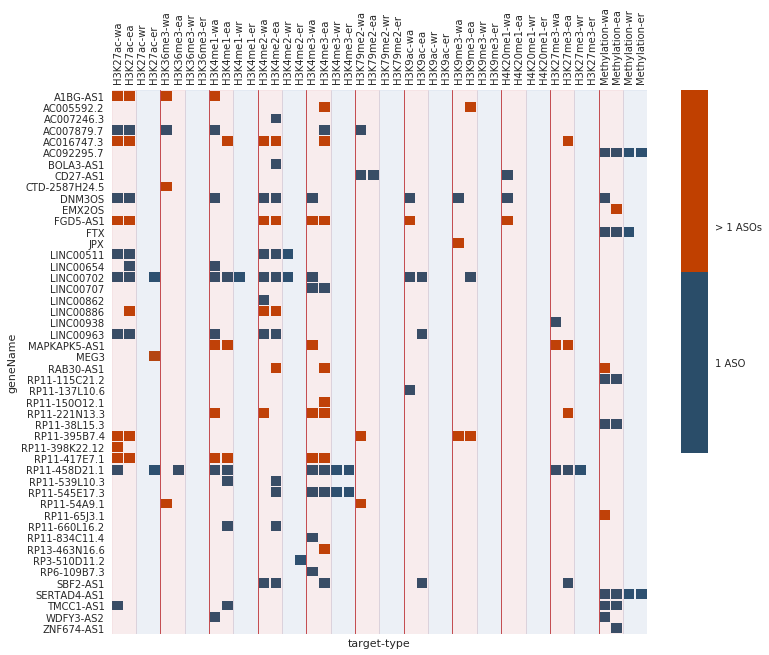

In [20]:
sns.set(color_codes=True)
rcParams['figure.figsize'] = 12,10
rcParams["patch.force_edgecolor"] = True

data = getDataWithoutASOs(iMARGI=False)
myColors = ("#FFFFFF", "#2a4d69", "#c04000")
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

mask = np.zeros_like(data.values)
mask[data.values < 1] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data, linewidths=0.5, cmap=cmap)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([1, 1.5])
colorbar.set_ticklabels(['1 ASO', '> 1 ASOs'])

ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 10)

for i, target in enumerate(targets):
    rect = patches.Rectangle((i*4, 0), 2, 92, linewidth=1, edgecolor='r', facecolor='r', alpha=0.1)
    ax.add_patch(rect)
    rect = patches.Rectangle((i*4 + 2, 0), 2, 92, linewidth=1, edgecolor='b', facecolor='b', alpha=0.1)
    ax.add_patch(rect)
    ax.axvline(linewidth=1, color='r', x=(i + 1)*4)

/home/mazurovev/.local/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


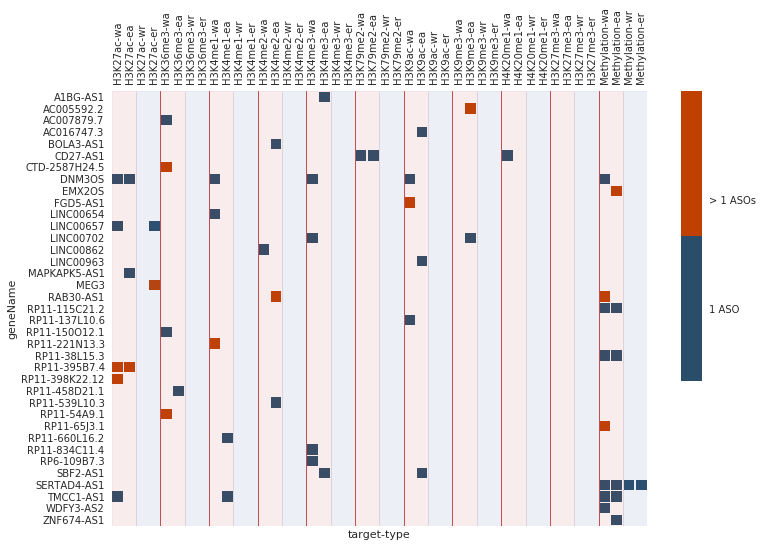

In [24]:
#iMARGI
sns.set(color_codes=True)
rcParams['figure.figsize'] = 12,8
rcParams["patch.force_edgecolor"] = True

data = getDataWithoutASOs(iMARGI=True)
myColors = ("#FFFFFF", "#2a4d69", "#c04000")
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

mask = np.zeros_like(data.values)
mask[data.values < 1] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data, linewidths=0.5, cmap=cmap)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([1, 1.5])
colorbar.set_ticklabels(['1 ASO', '> 1 ASOs'])

ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 10)

for i, target in enumerate(targets):
    rect = patches.Rectangle((i*4, 0), 2, 92, linewidth=1, edgecolor='r', facecolor='r', alpha=0.1)
    ax.add_patch(rect)
    rect = patches.Rectangle((i*4 + 2, 0), 2, 92, linewidth=1, edgecolor='b', facecolor='b', alpha=0.1)
    ax.add_patch(rect)
    ax.axvline(linewidth=1, color='r', x=(i + 1)*4)

In [111]:
data = getTableForAllMarks(annotation_prefix="fantom_aso").sort_index()

In [114]:
data.to_csv("../all_marks/table_for_all_marks.tsv", sep="\t")

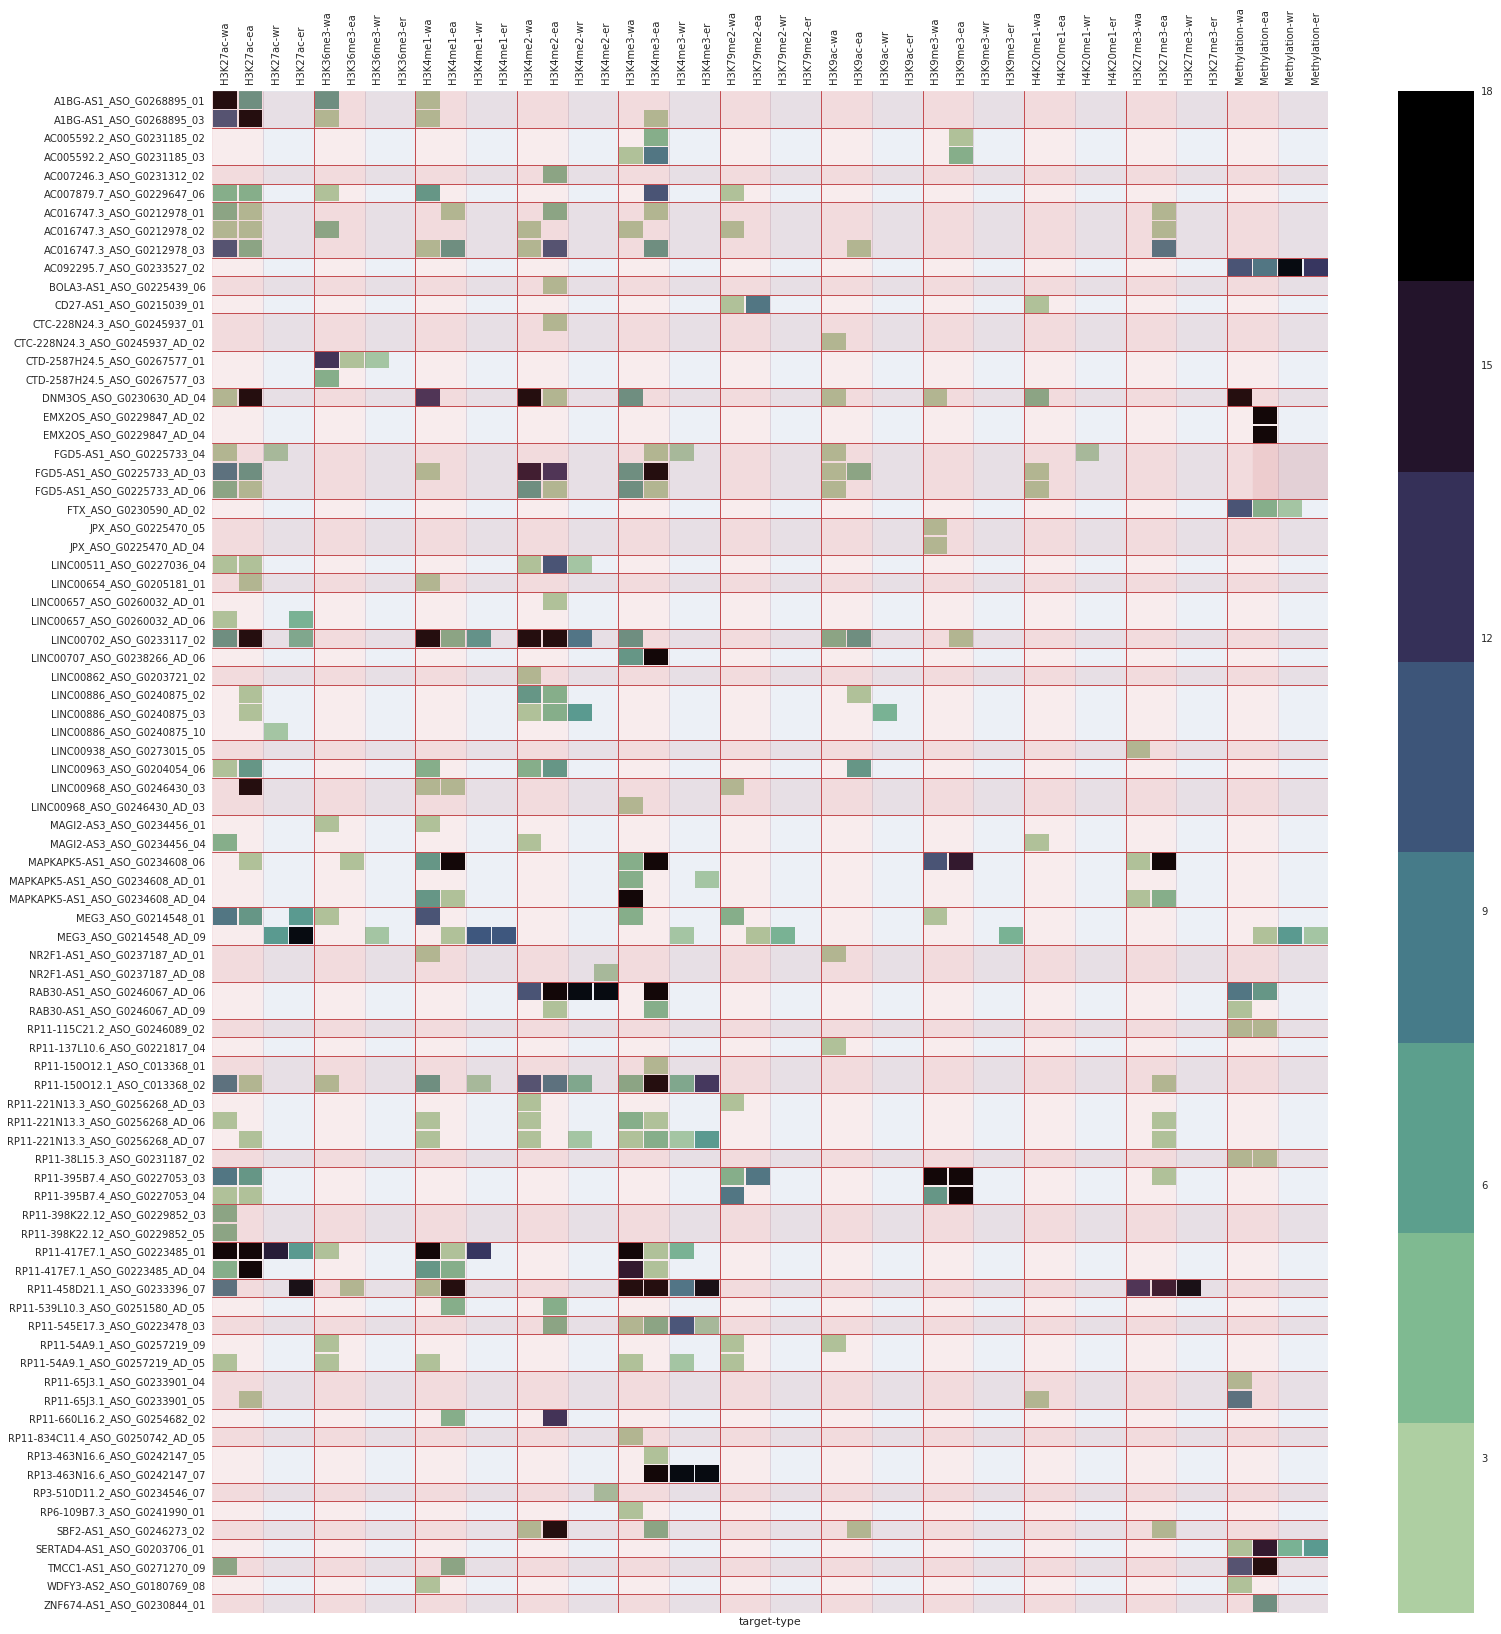

In [361]:
sns.set(color_codes=True)
rcParams['figure.figsize'] = 25,28
rcParams["patch.force_edgecolor"] = True

data = getTableForAllMarks(annotation_prefix="fantom_aso").sort_index()
mask = np.zeros_like(data.values)
mask[data.values < 1.3] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data, mask=mask, linewidths=0.5, cmap=sns.cubehelix_palette(8, start=.5, rot=-.75, dark=0, light=.75), vmax=18, vmin=1.3)
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 10)

for i, target in enumerate(targets):
    rect = patches.Rectangle((i*4, 0), 2, 92, linewidth=1, edgecolor='r', facecolor='r', alpha=0.1)
    ax.add_patch(rect)
    rect = patches.Rectangle((i*4 + 2, 0), 2, 92, linewidth=1, edgecolor='b', facecolor='b', alpha=0.1)
    ax.add_patch(rect)
    ax.axvline(linewidth=1, color='r', x=(i + 1)*4)
    
ax.axhline(linewidth=1, color='r', y=2)
rect = patches.Rectangle((0, 0), 92, 2, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=4)
ax.axhline(linewidth=1, color='r', y=5)
rect = patches.Rectangle((0, 4), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=6)
ax.axhline(linewidth=1, color='r', y=9)
rect = patches.Rectangle((0, 6), 92, 3, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=10)
ax.axhline(linewidth=1, color='r', y=11)
rect = patches.Rectangle((0, 10), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=12)
ax.axhline(linewidth=1, color='r', y=14)
rect = patches.Rectangle((0, 12), 92, 2, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=16)
ax.axhline(linewidth=1, color='r', y=17)
rect = patches.Rectangle((0, 16), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=19)
ax.axhline(linewidth=1, color='r', y=22)
rect = patches.Rectangle((0, 19), 92, 3, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=23)
ax.axhline(linewidth=1, color='r', y=25)
rect = patches.Rectangle((0, 23), 92, 2, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=26)
ax.axhline(linewidth=1, color='r', y=27)
rect = patches.Rectangle((0, 26), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=29)
ax.axhline(linewidth=1, color='r', y=30)
rect = patches.Rectangle((0, 29), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=31)
ax.axhline(linewidth=1, color='r', y=32)
rect = patches.Rectangle((0, 31), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=35)
ax.axhline(linewidth=1, color='r', y=36)
rect = patches.Rectangle((0, 35), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=37)
ax.axhline(linewidth=1, color='r', y=39)
rect = patches.Rectangle((0, 37), 92, 2, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=41)
ax.axhline(linewidth=1, color='r', y=44)
rect = patches.Rectangle((41, 19), 92, 3, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=46)
ax.axhline(linewidth=1, color='r', y=48)
rect = patches.Rectangle((0, 46), 92, 2, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=50)
ax.axhline(linewidth=1, color='r', y=51)
rect = patches.Rectangle((0, 50), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=52)
ax.axhline(linewidth=1, color='r', y=54)
rect = patches.Rectangle((0, 52), 92, 2, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=57)
ax.axhline(linewidth=1, color='r', y=58)
rect = patches.Rectangle((0, 57), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=60)
ax.axhline(linewidth=1, color='r', y=62)
rect = patches.Rectangle((0, 60), 92, 2, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=64)
ax.axhline(linewidth=1, color='r', y=65)
rect = patches.Rectangle((0, 64), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=66)
ax.axhline(linewidth=1, color='r', y=67)
rect = patches.Rectangle((0, 66), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=69)
ax.axhline(linewidth=1, color='r', y=71)
rect = patches.Rectangle((0, 69), 92, 2, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=72)
ax.axhline(linewidth=1, color='r', y=73)
rect = patches.Rectangle((0, 72), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=75)
ax.axhline(linewidth=1, color='r', y=76)
rect = patches.Rectangle((0, 75), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=77)
ax.axhline(linewidth=1, color='r', y=78)
rect = patches.Rectangle((0, 77), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=79)
ax.axhline(linewidth=1, color='r', y=80)
rect = patches.Rectangle((0, 79), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)
ax.axhline(linewidth=1, color='r', y=81)
rect = patches.Rectangle((0, 81), 92, 1, linewidth=1, edgecolor='white', facecolor='r', alpha=0.1)
ax.add_patch(rect)

In [20]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../all_marks/plots/Results_all_heatmap.png", bbox_inches='tight', pad_inches = 0)

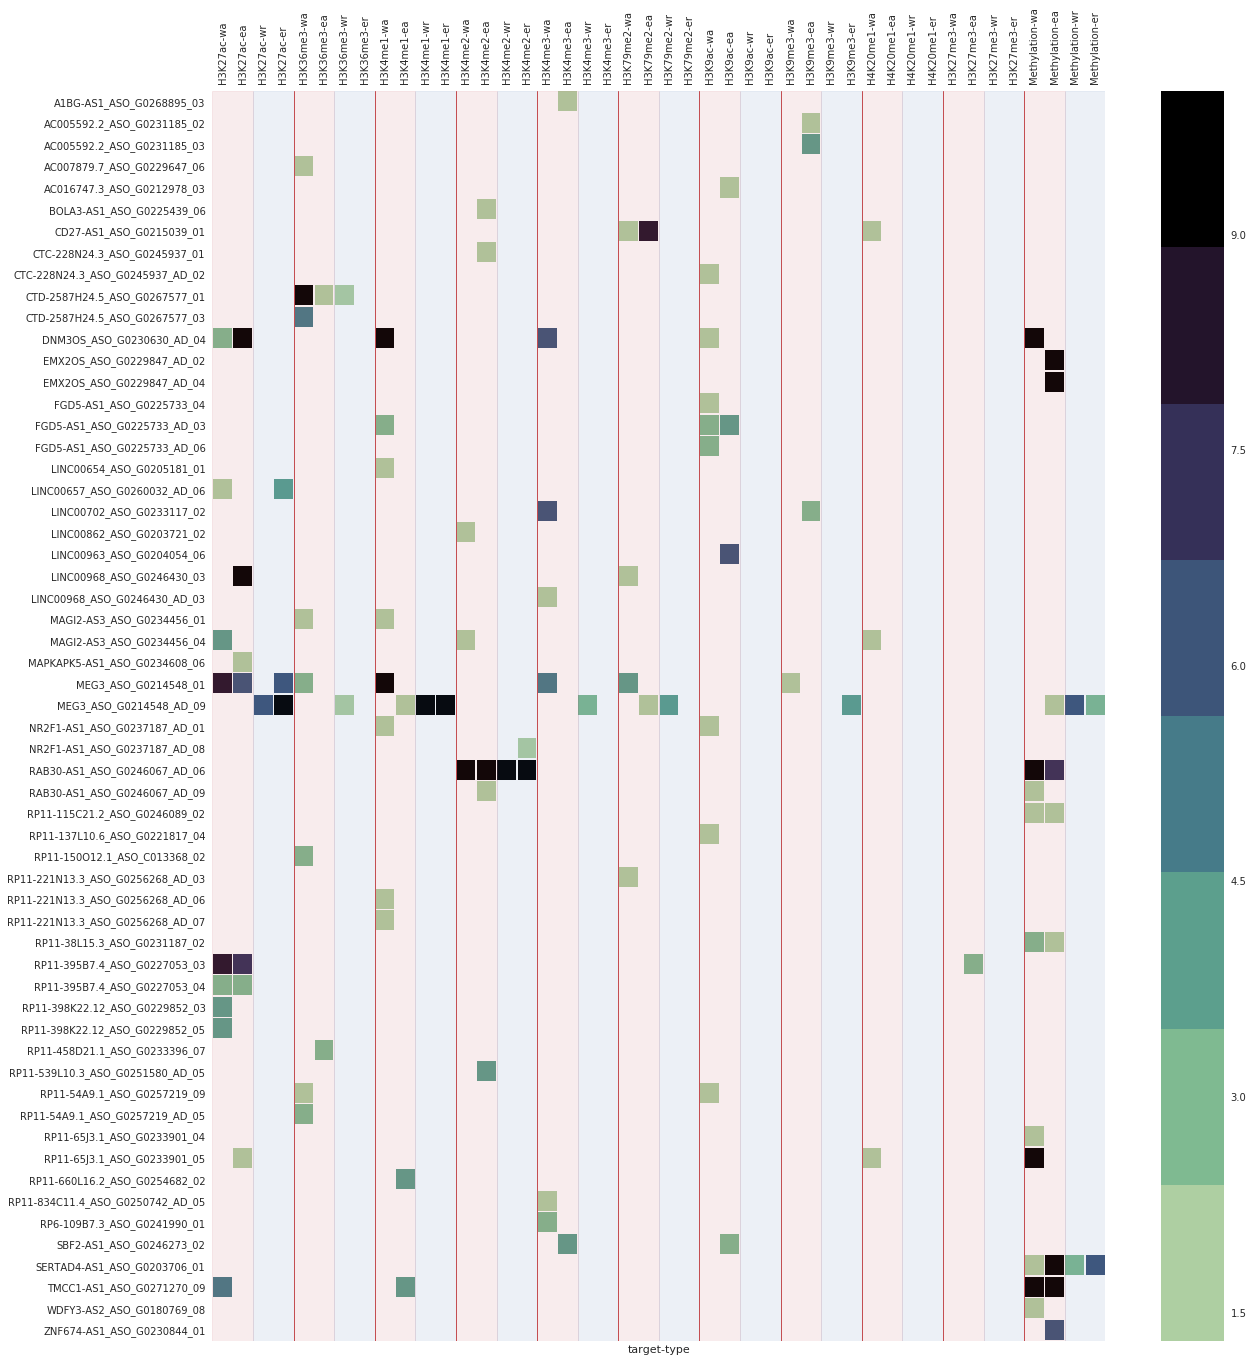

In [16]:
#Взятьтолько lncRNA, прошедшие iMARGI
sns.set(color_codes=True)
rcParams['figure.figsize'] = 20,23
rcParams["patch.force_edgecolor"] = True
data = getTableForAllMarks(iMARGI=True, annotation_prefix="fantom_aso").sort_index()
mask = np.zeros_like(data.values)
mask[data.values < 1.3] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data, mask=mask, linewidths=0.5, cmap=sns.cubehelix_palette(8, start=.5, rot=-.75, dark=0, light=.75), vmax=10, vmin=1.3)
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 10)

for i, target in enumerate(targets):
    rect = patches.Rectangle((i*4, 0), 2, 60, linewidth=1, edgecolor='r', facecolor='r', alpha=0.1)
    ax.add_patch(rect)
    rect = patches.Rectangle((i*4 + 2, 0), 2, 60, linewidth=1, edgecolor='b', facecolor='b', alpha=0.1)
    ax.add_patch(rect)
    ax.axvline(linewidth=1, color='r', x=(i + 1)*4)

In [32]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../all_marks/plots/Results_with_iMARGI_all_heatmap.png", bbox_inches='tight', pad_inches = 0)

In [ ]:
#===================================================================================================================================